In [1]:
#TODO: add text and explanation to this notebook

In [2]:
import IPython

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import torchaudio
import torch

import os,sys,inspect
sys.path.insert(0, "..")

from src.data import librispeech
from src.dataprocessing import transforms as T
from src.utils import hparams

pre_path = '../../'

In [3]:
path = "MelNet-SpeechGeneration/models/params/dummymodel_librispeech.yml"
hp = hparams.HParams.from_yaml(pre_path+path)

# I do not want to do the calculations on the GPU
hp["training"]["device"] = torch.device('cpu')

In [4]:
dataset_librispeech = librispeech.download_data(root=pre_path+hp.data.path, url=hp.data.url)
dataloader_librispeech = torch.utils.data.DataLoader(dataset_librispeech)
dataiter = iter(dataloader_librispeech)

In [5]:
waveform1, sample_rate1, utterance1, speaker_id1, chapter_id1, utterance_id1 = dataiter.next()
waveform2, sample_rate2, utterance2, speaker_id2, chapter_id2, utterance_id2 = dataiter.next()

## Analysing the spectrogram

In [6]:
def plot_hist(tensor):
    max_v = torch.max(tensor)
    min_v = torch.min(tensor)
    mean = torch.mean(tensor)
    std = torch.std(tensor)
    print(f"Max value: {max_v}")
    print(f"Min value: {min_v}")
    print(f"Mean value: {mean}")
    print(f"Std value: {std}")
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot histogram with linear scale in y-axis
    axes[0].hist(tensor.flatten().numpy(), bins=100)
    axes[0].set_title('Linear scale y-axis')

    axes[1].hist(tensor.flatten().numpy(), bins=100)
    axes[1].set_yscale('log')
    axes[1].set_title('Linear scale y-axis')

    plt.show()

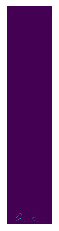

In [7]:
# Preparation and Transformation
spectrogram = T.wave_to_spectrogram(waveform1, hp)
T.plot_spectrogram(spectrogram, hp)

As we can see, values are very different and the maximum value is very big in comparison with the minimum.
Now, let's see the distribution of the values with a histogram.

Max value: 17100.953125
Min value: 1.5822321344826154e-14
Mean value: 7.690195560455322
Std value: 178.1921844482422


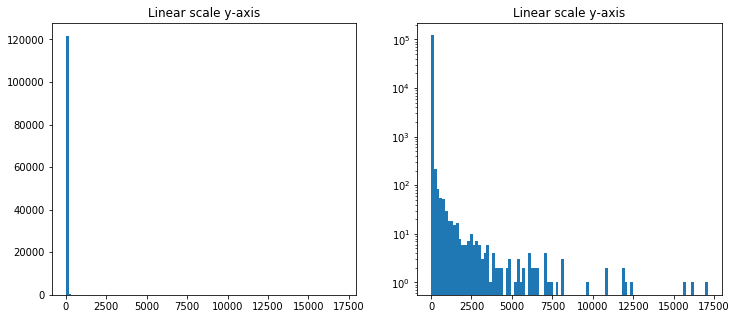

In [8]:
plot_hist(spectrogram)

In the spectrograms, we can see that the distibution is very skewed towards values close to 0.

# Analysing the melspectrogram

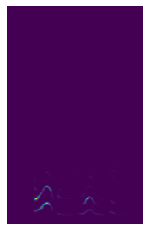

In [9]:
melspectrogram = T.wave_to_melspectrogram(waveform1, hp)
T.plot_melspectrogram(melspectrogram, hp)

Max value: 13630.6357421875
Min value: 3.39206618349408e-09
Mean value: 23.100574493408203
Std value: 277.91387939453125


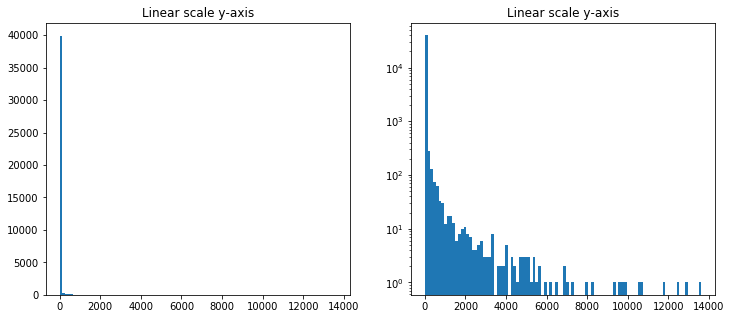

In [10]:
plot_hist(melspectrogram)

# Normalizing

Training for neural networks is greatly improved if the input values are normalized with the mean close to 1 and small standard deviation. Let's see ways to normalize spectrograms:

##### Min-max scaling
scaled_data = (data — min(data))/(max(data) — min(data)) 

This does not change the distribution of the values but all of them are in the range [0, 1]. The mean is still skewed towards 0. It does not handle outliers very well.

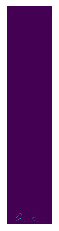

In [11]:
scaled_spectrogram = (spectrogram - torch.min(spectrogram)) / (torch.max(spectrogram) - torch.min(spectrogram))
T.plot_spectrogram(scaled_spectrogram, hp)

Max value: 1.0
Min value: 0.0
Mean value: 0.00044969405280426145
Std value: 0.010420015081763268


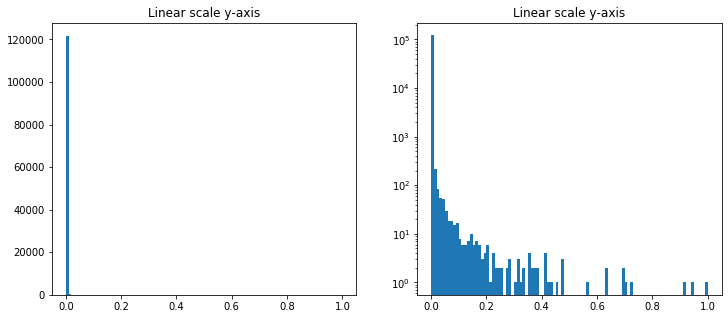

In [12]:
plot_hist(scaled_spectrogram)

##### Z-score scaling
scaled_data = (data - mean(data))/std(data)

The mean is 0 and handles a little better outliers. The distribution is still skewed towards 0.

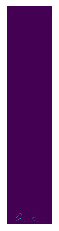

In [13]:
scaled_spectrogram = (spectrogram - torch.mean(spectrogram)) / torch.std(spectrogram)
T.plot_spectrogram(scaled_spectrogram, hp)

Max value: 95.9260025024414
Min value: -0.04315675050020218
Mean value: 2.5957325533454423e-07
Std value: 1.0


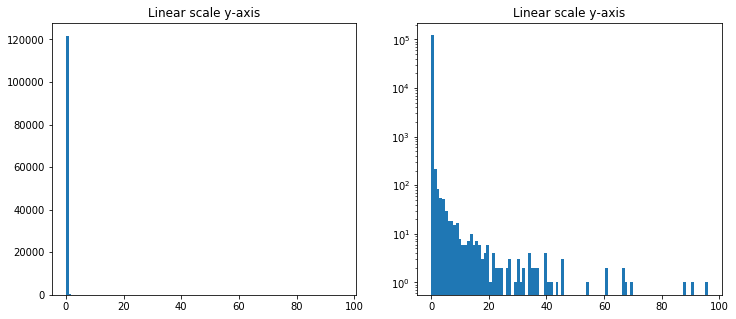

In [14]:
plot_hist(scaled_spectrogram)

##### Log scaling

scaled_data = log(data + 1e-10)

The small value (1e-10) is added to the data to avoid numerical issues. This is similar as transforming to dB.

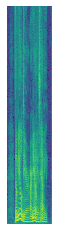

In [15]:
scaled_spectrogram = torch.log(spectrogram + 1e-10)
T.plot_spectrogram(scaled_spectrogram, hp)

Max value: 9.746889114379883
Min value: -23.025691986083984
Mean value: -7.843517780303955
Std value: 5.058341026306152


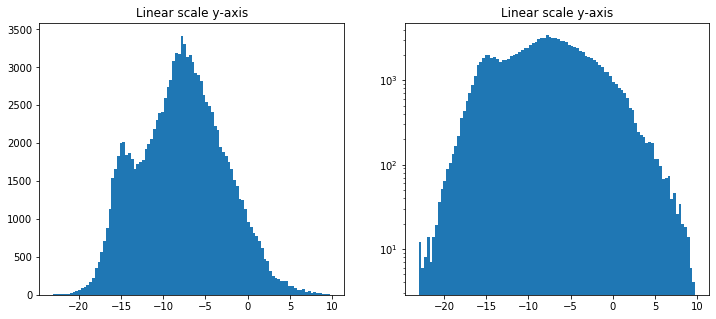

In [16]:
plot_hist(scaled_spectrogram)

##### Box-Cox

$scaled\_data = \frac{(data+\lambda_2)^{\lambda_1} - 1}{\lambda_1}$ if $\lambda_1 != 0$, $ln(data+\lambda_2)$ if $\lambda_1 = 0$.

In [17]:
from scipy import stats

/home/jorge/anaconda3/envs/speechgen/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


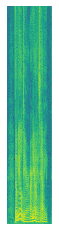

In [18]:
shape = spectrogram.shape
scaled_spectrogram, _ = stats.boxcox(spectrogram.flatten().numpy())
scaled_spectrogram = torch.from_numpy(scaled_spectrogram).view(shape)
T.plot_spectrogram(scaled_spectrogram, hp)

Max value: 9.360161781311035
Min value: -36.40084457397461
Mean value: -8.22163200378418
Std value: 5.397729873657227


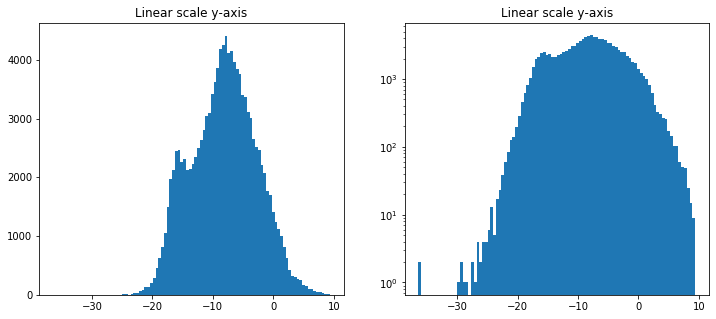

In [19]:
plot_hist(scaled_spectrogram)

##### Log scaling + Z-score scaling

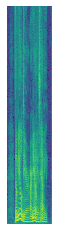

In [20]:
scaled_spectrogram = torch.log(spectrogram + 1e-10)
scaled_spectrogram = (scaled_spectrogram - torch.mean(scaled_spectrogram)) / torch.std(scaled_spectrogram)
T.plot_spectrogram(scaled_spectrogram, hp)

Max value: 3.4775049686431885
Min value: -3.0014138221740723
Mean value: 2.5557980620760645e-07
Std value: 1.0


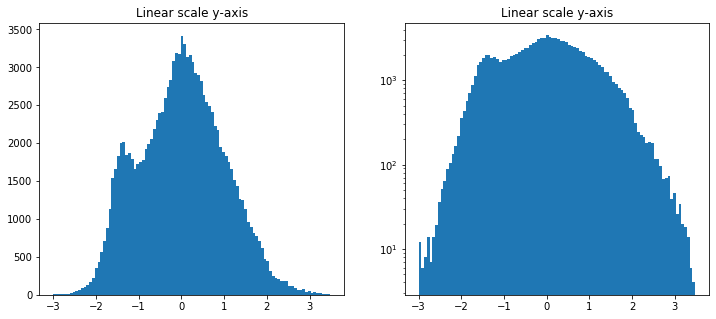

In [21]:
plot_hist(scaled_spectrogram)

#### Final solution:


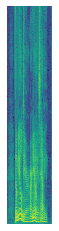

In [22]:
spectrogram_db = T.amplitude_to_db(spectrogram, hp)
T.plot_spectrogram(spectrogram_db, hp)

Max value: 42.330204010009766
Min value: -100.0
Mean value: -34.066001892089844
Std value: 21.97284507751465


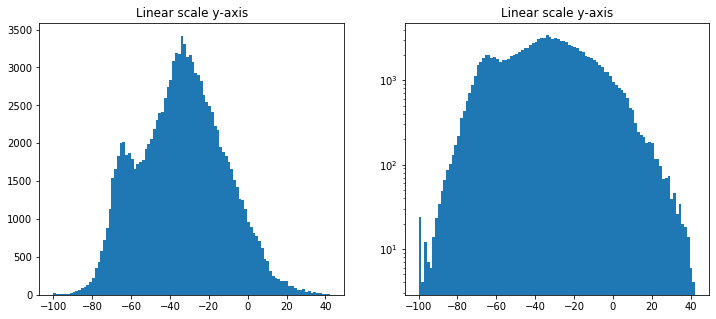

In [23]:
plot_hist(spectrogram_db)

Max value: 0.22330203652381897
Min value: -1.2000000476837158
Mean value: -0.54066002368927
Std value: 0.21972845494747162


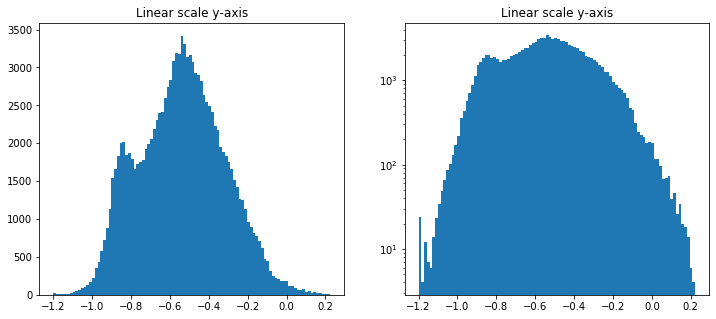

In [24]:
reference_db = 20
min_db = -100

scaled_spectrogram_db = spectrogram_db - reference_db
scaled_spectrogram_db = scaled_spectrogram_db / -min_db
plot_hist(scaled_spectrogram_db)

Max value: 1.0
Min value: 0.0
Mean value: 0.4591951370239258
Std value: 0.2178267240524292


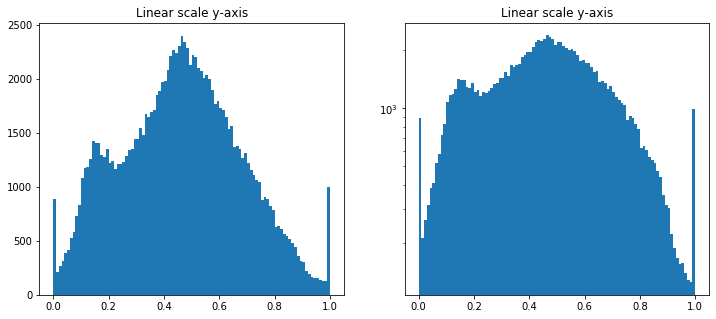

In [25]:
scaled_spectrogram = torch.clamp(scaled_spectrogram_db, min=-1.0, max=0.0) + 1.0
plot_hist(scaled_spectrogram)

Let's define the function to pre process and post process

In [26]:
def pre_processing(spectrogram, hp, reference_db, min_db):
    scaled = T.amplitude_to_db(spectrogram, hp)
    scaled = scaled - reference_db
    scaled = (scaled - min_db) / -min_db
    scaled = torch.clamp(scaled, min=0, max=1)
    return scaled

In [27]:
def post_processing(spectrogram, hp, reference_db, min_db):
    scaled = torch.clamp(spectrogram, min=0, max=1)
    scaled = (scaled * -min_db) + min_db
    scaled = scaled + reference_db
    scaled = T.db_to_amplitude(scaled, hp)
    exp = 2 if hp.audio.spectrogram_type == 'power' else 1
    scaled = torch.pow(scaled, exp)
    return scaled

Max value: 1.0
Min value: 0.0
Mean value: 0.4591951370239258
Std value: 0.2178267240524292


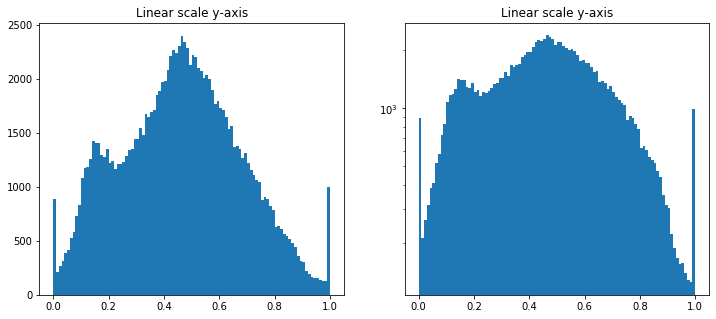

In [28]:
reference_db = 20
min_db = -100

scaled_spectrogram = pre_processing(spectrogram, hp, reference_db, min_db)
plot_hist(scaled_spectrogram)

Max value: 10000.0
Min value: 1.0000000168623835e-16
Mean value: 95.48957061767578
Std value: 902.3969116210938


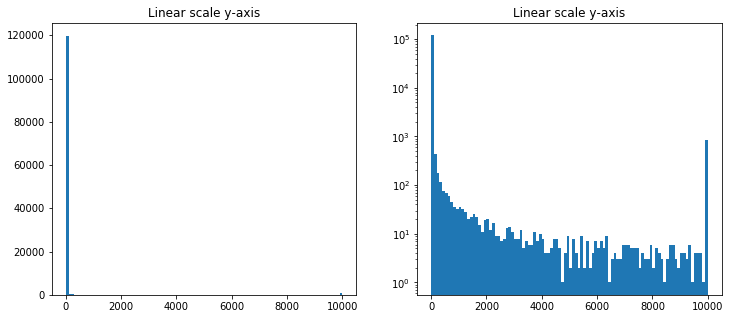

In [29]:
original_spectrogram = post_processing(scaled_spectrogram, hp, reference_db, min_db)
plot_hist(original_spectrogram)

In [30]:
torch.abs(original_spectrogram - spectrogram).sum()/original_spectrogram.sum()

tensor(0.9248)

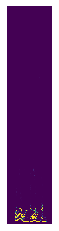

In [31]:
T.plot_spectrogram(original_spectrogram, hp)

In [32]:
wave = T.spectrogram_to_wave(original_spectrogram, hp, n_iter=500)

Let's see the impact of preprocessing and postprocessing in the audio

In [33]:
print("Original:")
IPython.display.Audio(data=waveform1.flatten().numpy(), rate=hp.audio.sample_rate)

Original:


In [34]:
print("Reconstructed:")
IPython.display.Audio(data=wave.flatten().numpy(), rate=hp.audio.sample_rate)

Reconstructed:


## References

https://medium.com/using-cnn-to-classify-audio/effects-of-spectrogram-pre-processing-for-audio-classification-a551f3da5a46
https://www.codecademy.com/articles/normalization#:~:text=Min%2Dmax%20normalization%3A%20Guarantees%20all,with%20the%20exact%20same%20scale.
https://arxiv.org/pdf/1709.01922.pdf
https://github.com/keithito/tacotron/blob/master/util/audio.py